In [1]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt 

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

# Set-up experiment

# Mnist dataset experiment 

In [2]:
# Load the CSV file
Mnist_data = pd.read_csv("data\Mnist\mnist_train.csv")
Mnist_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
def image_show (df:pd.DataFrame, shape: tuple[int,int], index: int, column_to_drop:str = ""): 
    if len(column_to_drop) != 0:
        Mnist_data_resized = np.array(df.iloc[index].drop(column_to_drop)).reshape(shape[0],shape[1])
        plt.imshow(Mnist_data_resized, cmap='gray')
        plt.show()
    else:
        Mnist_data_resized = np.array(df.iloc[index]).reshape(shape[0],shape[1])
        plt.imshow(Mnist_data_resized, cmap='gray')
        plt.show()

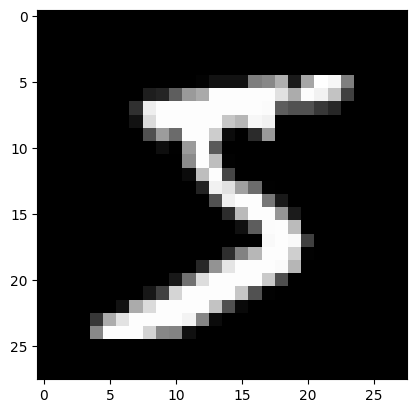

In [4]:
image_show(Mnist_data,(28,28),0,"label")

In [167]:
Mnist_data_rotated = np.rot90(Mnist_data.iloc[:, 1:].values.reshape(-1, 28, 28), k=-1, axes=(1, 2))
Mnist_data_rotated = Mnist_data_rotated.reshape(60000, 784)
Mnist_data_rotated_df = pd.DataFrame(Mnist_data_rotated.reshape(-1, 28*28))
Mnist_data_rotated_df['label'] = Mnist_data['label']
Mnist_data_rotated_df.head()
column_names = Mnist_data.columns[1:]
Mnist_data_rotated_df.columns = column_names.tolist() + ['label']
Mnist_data_rotated_df.to_csv("data/Mnist/mnist_test_rotated.csv")

## Test DDAL on rotated images

In [11]:
from ddal import DDAL
from batcher import BatchGenerator

In [12]:
t = DDAL()

In [21]:
def detect_drift(train_data: pd.DataFrame, test_data: pd.DataFrame, batch_size: int, target_column: str, training_split:int=5000):
    if test_data is None:
        df_y = train_data[target_column] 

        training_proportion = int(2 * len(train_data) / training_split)
        df_x_train = train_data[0:training_proportion].drop(columns=[target_column])
        df_y_train = df_y[0:training_proportion]

        data_test = train_data.iloc[training_proportion:len(train_data)].reset_index(drop=True)
    else:
        
        df_x_train = train_data.drop(columns=[target_column])
        df_y_train = train_data[target_column]

        data_test = test_data

    print(f"Size of train_data: {len(df_x_train)}, Size of test_data: {len(data_test)}")

    y_out = np.ndarray([1, df_y_train.nunique()])

    classifier = tree.DecisionTreeClassifier()
    classifier.fit(df_x_train, df_y_train)
    print("Training finished: proceeding to detecting drift")

    batcher = BatchGenerator(batch_size=batch_size,df = data_test)

    ddal_detector = DDAL(size_batch=batch_size, theta=0.005, lambida=0.95)

    for batch_test in batcher:
        batch_test = batch_test.drop(columns=[target_column])
        for index, _ in batch_test.iterrows():
            y_pred = classifier.predict_proba(batch_test.iloc[[index]])
            y_out = np.concatenate((y_out, y_pred))
            max_y_pred_prob = y_pred.max()
            ddal_detector.count_selected_instances(max_y_pred_prob)

        ddal_detector.compute_current_density()

        if ddal_detector.detection_module():
            print('Drift Detected')
            ddal_detector.reset()

        # else:
        #     print('No drift detected')


In [22]:
detect_drift(train_data = Mnist_data.iloc[0:1000],test_data = None , batch_size= 50,target_column = 'label',training_split = 100)

Size of train_data: 20, Size of test_data: 980
Training finished: proceeding to detecting drift


no drift detect with those settings
detect_drift(train_data = Mnist_data,test_data = None , batch_size= 50,target_column = 'label',training_split = 100)

In [24]:
detect_drift(train_data = Mnist_data.iloc[0:1000],test_data = Mnist_data_rotated , batch_size= 50,target_column = 'label',training_split = 100)

Size of train_data: 1000, Size of test_data: 60000
Training finished: proceeding to detecting drift


AttributeError: 'BatchGenerator' object has no attribute 'df'

# Bin

In [ ]:
# data_sin = pd.read_csv('../data/Sine.csv', index_col=0)
# data_sin['Classification'] = data_sin['Classification'].map({'Initially Negative':0,'Initially Positive':1})
# data_sin['Concept Drift'] = data_sin['Concept Drift'].map({'After Concept Drift Negative':0,'After Concept Drift Positive':1})

# data_sin_tmp = data_sin.copy()
# df_y = data_sin_tmp['Classification']

# training_proportion = int(2*len(data_sin)/5000)
# print(training_proportion)
# df_x_train = data_sin_tmp[0:training_proportion].drop(columns=['Concept Drift','Classification'])
# df_y_train = df_y[0:training_proportion]

# data_test = data_sin_tmp.iloc[training_proportion:len(data_sin_tmp)].reset_index(drop=True)
# classifier = tree.DecisionTreeClassifier()
# classifier.fit(df_x_train, df_y_train)
# y_out = np.ndarray([1,2])
# batcher = BatchGenerator(500,data_test)
# ddal = DDAL(size_batch=500, theta=0.005, lambida=0.90)

# for batch_test in batcher:
#     batch_test = batch_test.drop(columns=['Concept Drift','Classification'])
#     for index,_ in batch_test.iterrows():
#         y_pred = classifier.predict_proba(batch_test.iloc[[index]])
#         y_out = np.concatenate((y_out,y_pred))
#         max_y_pred_prob = y_pred.max()
#         ddal.count_selected_instances(max_y_pred_prob)

#     ddal.compute_current_density()

#     if ddal.detection_module():
#         print('Drift Detected')
#         ddal.reset()
        
#     else:
#         print('No drift detected')

In [ ]:
# # Load the CSV file
# Sine_data = pd.read_csv("data\Sine.csv", index_col=0)
# Sine_data.head()